In [1]:
from mnist import MNIST
from sklearn.utils import shuffle
from collections import defaultdict
import numpy as np
import math
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
mndata = MNIST('C:\\Users\\Divya\\Google Drive\\Acads\\Courses-Winter2018\\CSE253-NeuralNetworks\\neuralnets253')
mndata.gz = True
images, labels = mndata.load_training() #Images is a list of 60000 images of 784 dimensions, Labels is a list of 60000 ints
testImages, testLabels = mndata.load_testing()

In [2]:
def addBiasToInput(imgs, tstImgs):
    imgs = np.array(imgs)
    tstImgs = np.array(tstImgs)
    imgs = np.insert(imgs, 0, 1, axis=1)
    tstImgs = np.insert(tstImgs, 0, 1, axis=1)
    return imgs, tstImgs
    
def roughZScoring(imgs, tstImgs):
    imgs = (imgs/127.5)-1.0
    tstImgs = (tstImgs/127.5)-1.0
    return imgs, tstImgs

def sigmoid(x):
    return 1/(1+np.exp(-1*x))

def dsigmoid(x):
    return x*(1-x);

def tanh(x):
    return np.tanh(x);

def dtanh(x):
    return (1 - x*x);

def labelsToVectForm(labels):
    vectForm = np.zeros((len(labels), labelNums))
    for i in range(len(labels)):
        vectForm[i][labels[i]] = 1
    return vectForm

def softmax(x):
    return np.exp(x)/np.sum(np.exp(x), axis=1, keepdims = True)

def reLU(x):
    return np.maximum(x, 0.1*x, x);

def derReLU(x):
    x[x>0] = 1
    x[x<=0] = 0.1
    return x

def calculateOutput1Layer(x, W1, W2):
    A1 = x.dot(W1)
    Z1 = sigmoid(A1)
    X2 = np.insert(Z1, 0, 1, axis=1)
    A2 = X2.dot(W2)
    Y = softmax(A2)
    return Y

def calculateOutput2Layers(x, W1, W2, W3, activation):
    A1 = x.dot(W1)
    if(activation==reLU):
        A1 = A1/(np.ptp(A1)/2)-1
    Z1 = activation(A1)
    X2 = np.insert(Z1, 0, 1, axis=1)
    A2 = X2.dot(W2)
    if(activation==reLU):
        A2 = A2/(np.ptp(A2)/2)-1
    Z2 = activation(A2)
    X3 = np.insert(Z2, 0, 1, axis=1)
    A3 = X3.dot(W3)
    Y = softmax(A3)
    return Y

def calculateCost(xLen, t, Y):
    return -(1/xLen)*(np.sum(np.multiply(t, np.log(Y))))

def calculateAccuracy(Y, labels):
    predClass = np.argmax(Y, axis=1)
    return accuracy_score(labels, predClass)

In [3]:
images, testImages = addBiasToInput(images, testImages)
images, testImages = roughZScoring(images, testImages)
testLabels = np.array(testLabels)
hiddenUnits = 64
inputDims = len(images[0])
miniBatchSize = 128
labelNums = 10

In [4]:
testLabels.shape

(10000,)

In [5]:
from sklearn.model_selection import train_test_split
trainImages, validImages, trainLabels, validLabels = train_test_split(images, labels, test_size=0.10)

In [6]:
t_train = labelsToVectForm(trainLabels)
t_test = labelsToVectForm(testLabels)
t_validation = labelsToVectForm(validLabels)
x = trainImages
t = t_train

In [19]:
def twoLayerNeuralNetwork(learningRates, iters, nesterovMom, activation, hiddenLayerNumber, dropout=False, dropoutProb=1.0):
    global trainImages, trainLabels, testImages, testLabels, validImages, validLabels, t_train, t_test, t_validation
    results = defaultdict(list)
    for lR in learningRates:
        #initializing weights
        W1 = np.random.normal(loc=0.0, scale=1/math.sqrt(785), size=(785, hiddenLayerNumber))
        W2 = np.random.normal(loc=0.0, scale=1/math.sqrt(hiddenLayerNumber+1), size=(hiddenLayerNumber+1, hiddenLayerNumber))
        W3 = np.random.normal(loc=0.0, scale=1/math.sqrt(hiddenLayerNumber+1), size=(hiddenLayerNumber+1, 10))

        #initializing momentum
        v1 = np.zeros(W1.shape)
        v2 = np.zeros(W2.shape)
        v3 = np.zeros(W3.shape)

        #variables for recording min error state of the model
        prevValCost = float('inf')
        minValCost = float('inf')
        valAccAtMinCost = 0.0
        stopConditionCount = 0
        epochAtMinWeight = 0
        stoppingIteration = 0

        #variables to track the error and accuracy as model is trained
            testCost = []
            valCost = []
            trainCost = []
            testAcc = []
            valAcc = []
            trainAcc = []

        print("------ Running for learning rate: ",lR,"-------")

        for epoch in range(iters):
            trainImages, t_train, trainLabels = shuffle(trainImages, t_train, trainLabels)
            for b in range(batches):
                x = trainImages[b*batch_size:(b+1)*batch_size]
                t = t_train[b*batch_size:(b+1)*batch_size]

                #forward propagation
                A1 = x.dot(W1)
                if(activation==reLU):
                    A1 = A1/(np.ptp(A1)/2)-1.0
                Z1 = activation(A1)
                if(dropout):
                    dropoutMat = (np.random.rand(*Z1.shape)<dropoutProb)/dropoutProb
                    Z1 *= dropoutMat
                X2 = np.insert(Z1, 0, 1, axis=1)
                A2 = X2.dot(W2)
                if(activation==reLU):
                    A2 = A2/(np.ptp(A2)/2)-1.0
                Z2 = activation(A2)
                if(dropout):
                    dropoutMat = (np.random.rand(*Z2.shape)<dropoutProb)/dropoutProb
                    Z2 *= dropoutMat
                X3 = np.insert(Z2, 0, 1, axis=1)
                A3 = X3.dot(W3)
                Y = softmax(A3)

                # Backward propagation
                W3_nobias = np.delete(W3, (0), axis=0)
                summation_l = (Y-t).dot(W3_nobias.T)
                if(activation==reLU):
                    g_derivative = derReLU(A2)
                elif(activation==sigmoid):
                    g_derivative = dsigmoid(Z2)
                elif(activation==tanh):
                    g_derivative = dtanh(Z2)
                delE_ak = np.multiply(summation_l, g_derivative);
                delE_Wjk = X2.T.dot(delE_ak)
                W2_nobias = np.delete(W2, (0), axis=0)
                summation_k = np.matmul(delE_ak, W2_nobias)
                if(activation==reLU):
                    g2_derivative = derReLU(A1)
                elif(activation==sigmoid):
                    g2_derivative = dsigmoid(Z1)
                elif(activation==tanh):
                    g2_derivative = dtanh(Z1)
                delE_aj = np.multiply(summation_k, g2_derivative)
                delE_Wij = x.T.dot(delE_aj)
                
#                 print("Backward done")
                
                v3_prev = v3
                v2_prev = v2
                v1_prev = v1

                v3 = decayRate*v3 - (lR/len(x))*((X3.T.dot(Y-t)))
                v2 = decayRate*v2 - (lR/len(x))*(delE_Wjk)
                v1 = decayRate*v1 - (lR/len(x))*(delE_Wij)

                #weight update
                if(nesterovMom):
                    W3 = W3 - decayRate*v3_prev + (1+decayRate)*v3
                    W2 = W2 - decayRate*v2_prev + (1+decayRate)*v2
                    W1 = W1 - decayRate*v1_prev + (1+decayRate)*v1 
                else:
                    W3 = W3 + v3
                    W2 = W2 + v2
                    W1 = W1 + v1
                    
            # Calculating error and accuracy w.r.t updated weights after one iteration through the complete dataset
            y_train = calculateOutput2Layers(x=trainImages, W1=W1, W2=W2, W3=W3, activation=activation)
            currTrainCost = calculateCost(xLen=len(trainImages), t=t_train, Y=y_train)
            currTrainAcc = calculateAccuracy(Y=y_train, labels=trainLabels)
            trainCost.append(currTrainCost)
            trainAcc.append(currTrainAcc)

            y_val = calculateOutput2Layers(x=validImages, W1=W1, W2=W2, W3=W3, activation=activation)
            currValCost = calculateCost(xLen=len(validImages), t=t_validation, Y=y_val)
            currValAcc = calculateAccuracy(Y=y_val, labels=validLabels)
            valCost.append(currValCost)
            valAcc.append(currValAcc)

            y_test = calculateOutput2Layers(x=testImages, W1=W1, W2=W2, W3=W3, activation=activation)
            currTestCost = calculateCost(xLen=len(testImages), t=t_test, Y=y_test)
            currTestAcc = calculateAccuracy(Y=y_test, labels=testLabels)
            testCost.append(currTestCost)
            testAcc.append(currTestAcc)
            
            if(epoch%100==0):
                print("Validation cost: ",currValCost)

            if (currValCost < minValCost):
                epochAtMinWeight = epoch
                minValCost = currValCost
                valAccAtMinCost = currValAcc
                results[lR].clear()
                results[lR].append([currTrainCost, currTrainAcc, currValCost, currValAcc, currTestCost, currTestAcc])

            # Early stopping
            if (currValCost >= prevValCost):
                stopConditionCount += 1
                if (stopConditionCount >= 5):
                    stoppingIteration = epoch
                    break
            else:
                stopConditionCount = 0
            prevValCost = currValCost

        print("Iteration of min weights: ", epochAtMinWeight)
        print("Stopping iteration: ", stoppingIteration)
        print("Train cost, Train Acc, Val cost, Val accuracy, Test cost, Test Acc", results[lR][0])

        plt.title(lR)
        plt.plot(trainCost, label="Train", color='blue')
        plt.plot(valCost, label="Validation", color='green')
        plt.plot(testCost, label="Test", color='red')
        plt.ylabel("Cost")
        plt.xlabel("Iterations")
        plt.legend()
        plt.show()

        plt.title(lR)
        plt.plot(trainAcc, label="Train", color='blue')
        plt.plot(valAcc, label="Validation", color='green')
        plt.plot(testAcc, label="Test", color='red')
        plt.ylabel("Accuracy")
        plt.xlabel("Iterations")
        plt.legend()
        plt.show()
    return results

In [20]:
epsilon = 0.001
batch_size = 128
batches = len(trainImages)//batch_size
learningRates =  [0.85, 0.5, 0.1, 0.05, 0.01]#, 0.001, 0.0001]#[0.0001, 0.0015, 0.1, 0.01, 0.015, 0.2, 0.001]#, 0.1, 0.01, 0.001, 0.0001] #[0.8, 0.5, 0.1]#, 0.01]
maxIters = 1000
decayRate = 0.9

------ Running for learning rate:  0.1 -------
Validation cost:  0.288654379894
Validation cost:  0.22621841232
Validation cost:  0.244684129579
Validation cost:  0.21532264787
Validation cost:  0.253267531149
Iteration of min weights:  322
Stopping iteration:  0
Train cost, Train Acc, Val cost, Val accuracy, Test cost, Test Acc [0.11746788681108354, 0.96299999999999997, 0.19127147651358423, 0.9448333333333333, 0.2312364842063874, 0.93830000000000002]


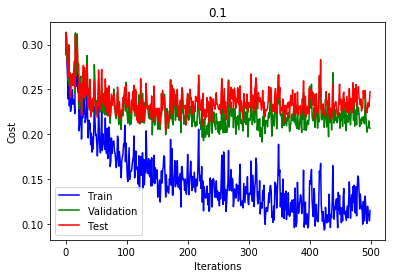

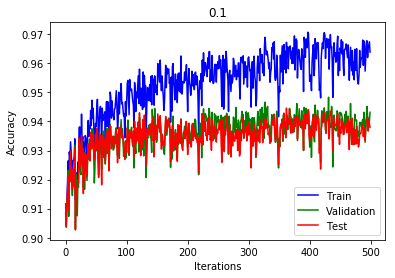

In [21]:
learningRates = [0.1]
results = twoLayerNeuralNetwork(learningRates, 500, True, tanh, 64, False, 0.5)

------ Running for learning rate:  0.1 -------
Validation cost:  0.271653238567
Iteration of min weights:  19
Stopping iteration:  68
Train cost, Train Acc, Val cost, Val accuracy, Test cost, Test Acc [0.038797421916765995, 0.98790740740740746, 0.10438268910555903, 0.97166666666666668, 0.10961194450079072, 0.96919999999999995]


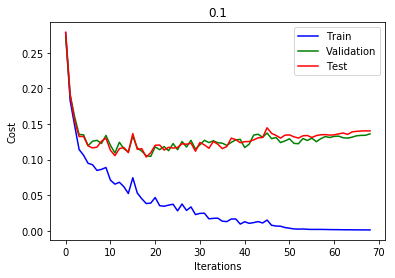

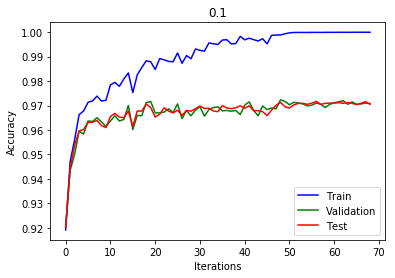

In [22]:
learningRates = [0.1]
results = twoLayerNeuralNetwork(learningRates, 500, True, sigmoid, 64, False, 0.5)

------ Running for learning rate:  0.1 -------
Validation cost:  0.348929679551


C:\Users\Divya\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  


Iteration of min weights:  4
Stopping iteration:  47
Train cost, Train Acc, Val cost, Val accuracy, Test cost, Test Acc [0.18146968811751665, 0.94590740740740742, 0.18277452295947802, 0.94883333333333331, 0.17759958108030849, 0.9456]


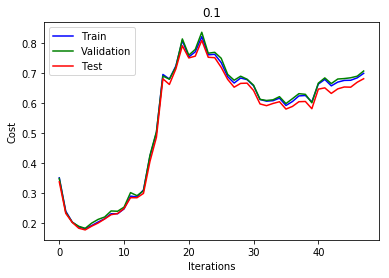

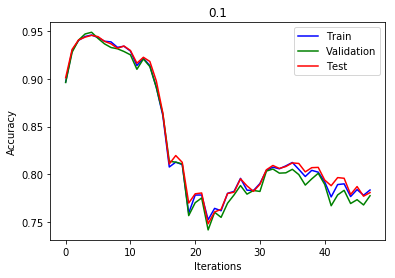

In [25]:
learningRates = [0.1]
results = twoLayerNeuralNetwork(learningRates, 500, True, sigmoid, 128, True, 0.8)

------ Running for learning rate:  0.1 -------
Validation cost:  0.272952658021
Iteration of min weights:  25
Stopping iteration:  86
Train cost, Train Acc, Val cost, Val accuracy, Test cost, Test Acc [0.0085261438129422638, 0.99812962962962959, 0.085388056057688469, 0.97933333333333328, 0.096853033904649555, 0.97340000000000004]


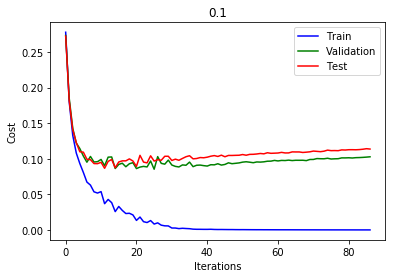

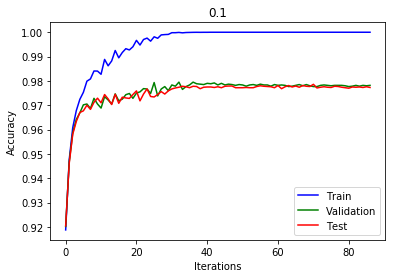

In [26]:
learningRates = [0.1]
results = twoLayerNeuralNetwork(learningRates, 500, True, sigmoid, 128, False, 0.8)

------ Running for learning rate:  0.01 -------
Validation cost:  2.14693804536
Iteration of min weights:  12
Stopping iteration:  36
Train cost, Train Acc, Val cost, Val accuracy, Test cost, Test Acc [0.4076526545889394, 0.88929629629629625, 0.40378576026623292, 0.88666666666666671, 0.40602406328444635, 0.89000000000000001]


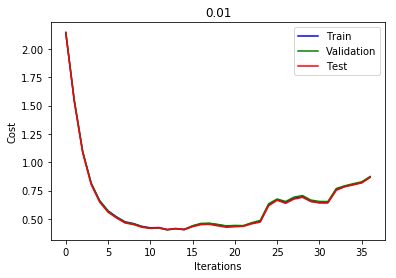

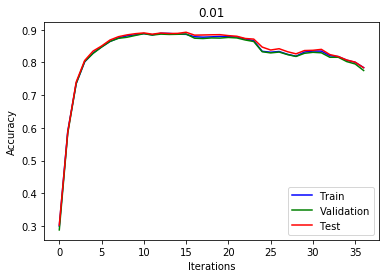

In [29]:
learningRates = [0.01]
results = twoLayerNeuralNetwork(learningRates, 500, True, sigmoid, 32, True, 0.8)

------ Running for learning rate:  0.1 -------
Validation cost:  0.244756764471
Iteration of min weights:  39
Stopping iteration:  56
Train cost, Train Acc, Val cost, Val accuracy, Test cost, Test Acc [0.12646978324689104, 0.9603518518518519, 0.17392801276607914, 0.95083333333333331, 0.16973027404415386, 0.95169999999999999]


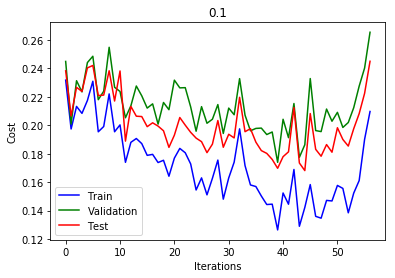

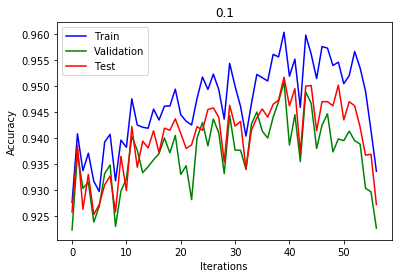

In [30]:
learningRates = [0.1]
results = twoLayerNeuralNetwork(learningRates, 500, True, tanh, 128, False, 0.8)

------ Running for learning rate:  0.01 -------
Validation cost:  0.301720531558
Iteration of min weights:  17
Stopping iteration:  96
Train cost, Train Acc, Val cost, Val accuracy, Test cost, Test Acc [0.051089973491605566, 0.98527777777777781, 0.10525821928201623, 0.96850000000000003, 0.099674609890170726, 0.96930000000000005]


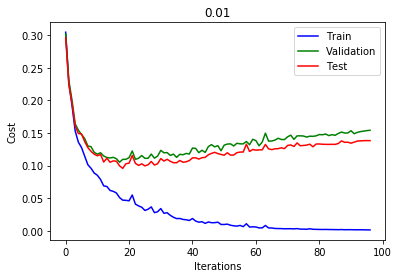

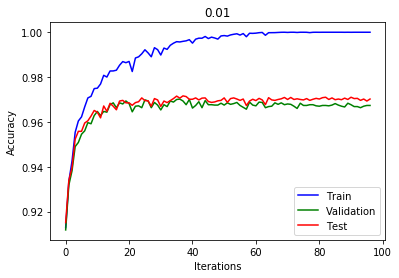

In [31]:
learningRates = [0.01]
results = twoLayerNeuralNetwork(learningRates, 500, True, tanh, 64, False, 0.8)

------ Running for learning rate:  0.01 -------
Validation cost:  0.274559914195
Iteration of min weights:  17
Stopping iteration:  55
Train cost, Train Acc, Val cost, Val accuracy, Test cost, Test Acc [0.034352306002798663, 0.99122222222222223, 0.084686600751574498, 0.97666666666666668, 0.084408658069103013, 0.97450000000000003]


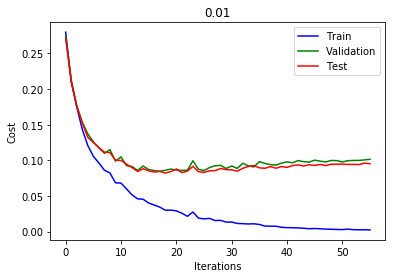

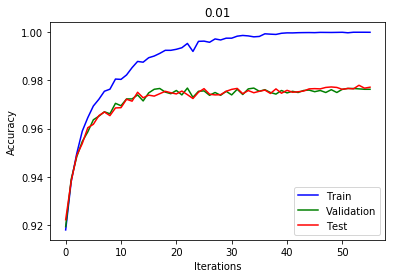

In [32]:
learningRates = [0.01]
results = twoLayerNeuralNetwork(learningRates, 500, True, tanh, 128, False, 0.8)

------ Running for learning rate:  0.85 -------
Validation cost:  0.654723225036
Validation cost:  0.307210405591
Validation cost:  0.292280546651
Validation cost:  0.321637840178
Iteration of min weights:  154
Stopping iteration:  340
Train cost, Train Acc, Val cost, Val accuracy, Test cost, Test Acc [0.20066968371466021, 0.93829629629629629, 0.25669414221555809, 0.9291666666666667, 0.2715445248734496, 0.92269999999999996]


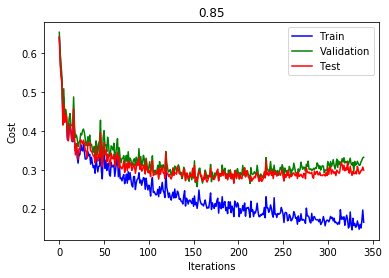

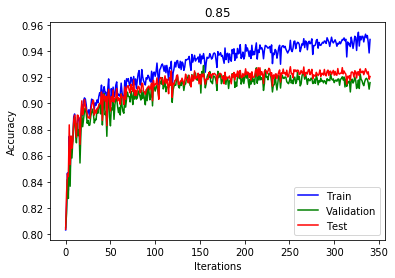

------ Running for learning rate:  0.5 -------
Validation cost:  0.405218241684
Validation cost:  0.201277134512
Validation cost:  0.260796893077
Validation cost:  0.301576732726
Iteration of min weights:  64
Stopping iteration:  378
Train cost, Train Acc, Val cost, Val accuracy, Test cost, Test Acc [0.1014043681810007, 0.96712962962962967, 0.18983660658406543, 0.9468333333333333, 0.17302124044871769, 0.95230000000000004]


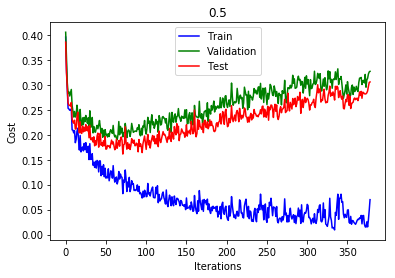

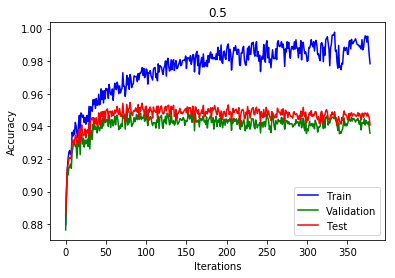

------ Running for learning rate:  0.1 -------
Validation cost:  0.277232823118
Validation cost:  0.165633528888
Validation cost:  0.189072023308
Iteration of min weights:  17
Stopping iteration:  266
Train cost, Train Acc, Val cost, Val accuracy, Test cost, Test Acc [0.044371385111306449, 0.98735185185185181, 0.11215570029678658, 0.96766666666666667, 0.10549424138354485, 0.96870000000000001]


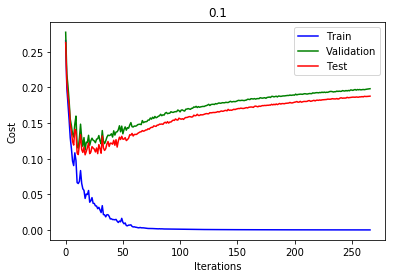

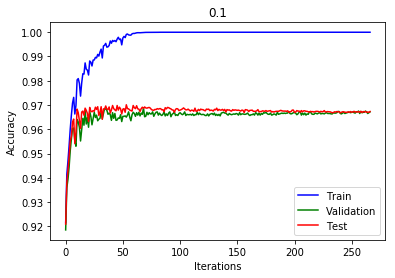

------ Running for learning rate:  0.05 -------
Validation cost:  0.352194075262
Validation cost:  0.154522549678
Validation cost:  0.178301219
Validation cost:  0.1929160302
Iteration of min weights:  28
Stopping iteration:  300
Train cost, Train Acc, Val cost, Val accuracy, Test cost, Test Acc [0.033538086107818964, 0.9914074074074074, 0.11640278541953702, 0.96583333333333332, 0.11098506940804906, 0.96660000000000001]


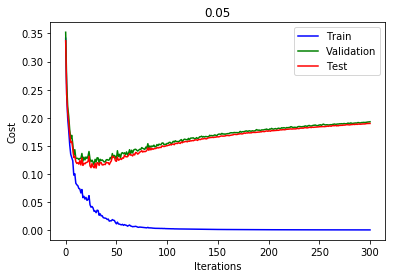

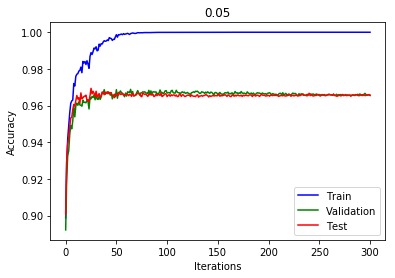

------ Running for learning rate:  0.01 -------
Validation cost:  0.910805673004
Validation cost:  0.0995146916583
Iteration of min weights:  102
Stopping iteration:  140
Train cost, Train Acc, Val cost, Val accuracy, Test cost, Test Acc [0.026780585956221615, 0.99512962962962959, 0.096119240241239648, 0.96766666666666667, 0.10039620248181357, 0.97060000000000002]


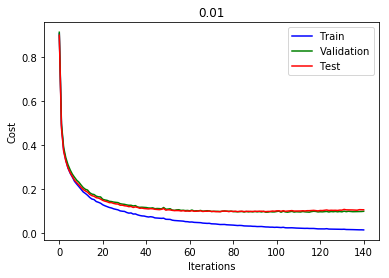

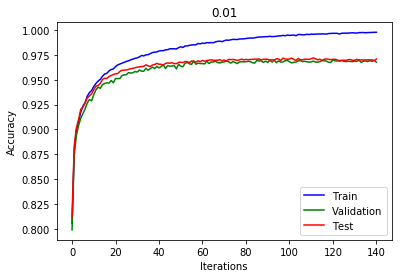

In [198]:
results = twoLayerNeuralNetwork(learningRates, 500)

------ Running for learning rate:  0.1 -------
Validation cost:  0.25406187382
Iteration of min weights:  15
Stopping iteration:  89
Train cost, Train Acc, Val cost, Val accuracy, Test cost, Test Acc [0.038272194029762077, 0.9892037037037037, 0.11284934418871828, 0.96733333333333338, 0.10373852325179583, 0.96840000000000004]


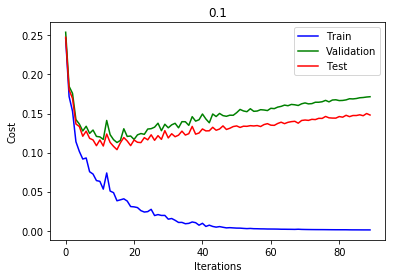

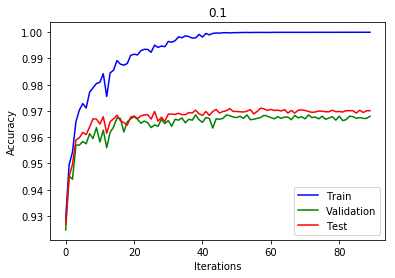

------ Running for learning rate:  0.01 -------
Validation cost:  0.877469938176
Iteration of min weights:  81
Stopping iteration:  88
Train cost, Train Acc, Val cost, Val accuracy, Test cost, Test Acc [0.038293097870638164, 0.99116666666666664, 0.1038653381943925, 0.96850000000000003, 0.095898462813862162, 0.96999999999999997]


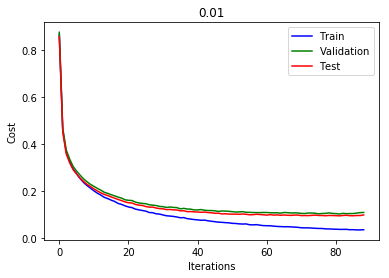

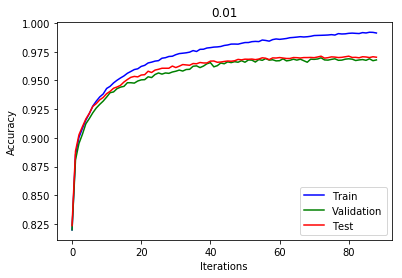

In [202]:
learningRates = [0.1, 0.01]
results = twoLayerNeuralNetwork(learningRates, 500, True)

------ Running for learning rate:  0.001 -------
Validation cost:  2.27887955773
Validation cost:  0.212113298415
Validation cost:  0.155827039904
Validation cost:  0.131715927754
Validation cost:  0.119527028427
Iteration of min weights:  498
Stopping iteration:  0
Train cost, Train Acc, Val cost, Val accuracy, Test cost, Test Acc [0.063817358256278434, 0.9839444444444444, 0.11304413835195484, 0.96666666666666667, 0.103638450393105, 0.96889999999999998]


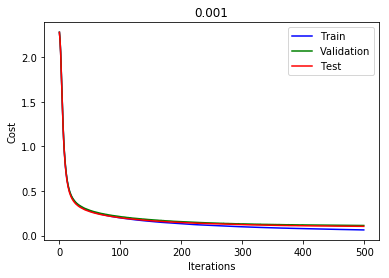

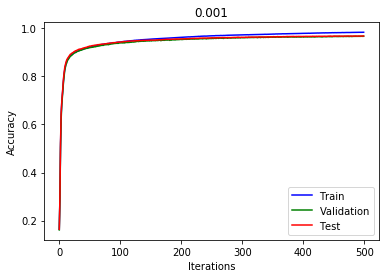

In [203]:
learningRates = [0.001]
results = twoLayerNeuralNetwork(learningRates, 500, True)

------ Running for learning rate:  0.01 -------
Validation cost:  2.29505849991
Validation cost:  1.70179476586
Validation cost:  1.74313717213
Validation cost:  1.77698791897
Validation cost:  1.81285544794
Validation cost:  1.83706749569
Iteration of min weights:  72
Stopping iteration:  555
Train cost, Train Acc, Val cost, Val accuracy, Test cost, Test Acc [1.7120085732945476, 0.31301851851851853, 1.6928007284907147, 0.32383333333333331, 1.7072942526133339, 0.31309999999999999]


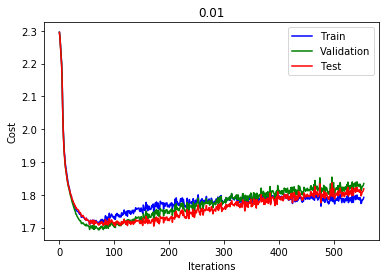

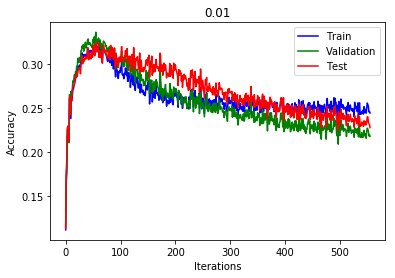

In [258]:
learningRates = [0.01]
results = twoLayerNeuralNetwork(learningRates, 1000, True, True)